# Exercise 4 Question 8

In [2]:
import tensorflow as tf
import numpy as np
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
tfd = tf.contrib.distributions

%matplotlib notebook 

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

## Encoder 

By using a Neural Network with one hidden layer, this function computes Q(z|x) by finding the parameters 
for its gaussian approximation, N($\mu_x$, $\sigma_x$). 

If the boolean constant_sigma is True, $\sigma_x$ could be simply set to a constant, i.e. 0.1. Otherwise, it is approximated in the Neural Network as a layer. Quoting the result from Exercise 1 Question 5, in order to prevent numerical overflow, the following expression is used to approximate $\sigma_x$: 

when x>0, log($\sigma_x$) = -log($1+e^{-x}$)

In our approximation, we apply nn.softplus on the input hidden layer, which computes log($1+e^{input}$). So with a small alteration, we compute the approximation of $\sigma_x$.

Then z is randomly sampled with reparameterisation. This will move the randomness out of deterministic nodes in the Neural Network, allowing backpropagation flow through with minimal uncertainty. 

In [ ]:
'''
Input data: tensor of float, of shape [?, 28, 28], could be the standardized training/test MNIST set that forms the first layer 
Input z_size: integer, size of the approximated latent variable, z
Input constant_sigma: tensor of boolean, determines our approximation method of sigma_z
Output z: tensor of shape [?,z_size], approximated latent variable, z
Output mu_z: tensor of shape [?,z_size], parameter for the approximated distribution Q(z|x)
'''
def encoder(data, z_size,constant_sigma): 
    x = tf.layers.flatten(data) #converts to 2D array of shape [?,784]
    x = tf.layers.dense(x, 200, tf.nn.relu)
    mu_z = tf.layers.dense(x, z_size)
    epsilon = np.random.normal(0,1) #maybe make it same shape as x?
    
    if constant_sigma == True:
        sigma_z = np.ones(z_size)*0.1 #contant covariance matrix of 0.1 I 
        z = mu_z + sigma_z * epsilon
    else:
        print('train sigma')
        log_sigma_z = -tf.layers.dense(-x, z_size, tf.nn.softplus)  #prevents numerical overflow
        z = mu_z + tf.math.exp(log_sigma_z)*epsilon
    return z, mu_z

## Decoder

This function takes the randomly sampled z as input, and generates the autoencoded version of x, which is $\hat{x}$,  via one hidden layer

In [113]:
'''
Input z: tensor of shape [?,z_size], approximated latent variable, z
Input data_size: array of size 2, the dimension of one original MNIST image, which is [28,28]
Ouput x_hat: tensor of shape [?,28**2], the autoencoder-decoded output
'''
def decoder(z, data_shape): 
    x = tf.layers.dense(z, 200, tf.nn.relu)
    x_hat = tf.layers.dense(x, np.prod(data_shape), tf.nn.relu) 
    return x_hat

## Loss

The loss is taken to be:
    $\frac{1}{N} \sum_{i=1}^{N} (\sum_{j=1}^{748} (x^{(i)}_j - \hat{x}^{(i)}_j)^2) + \sigma_x^2 \parallel \mu_z \parallel ^2 $ 

where $\sigma_x^2$ is assumed to be 0.1 

In [156]:
tf.reset_default_graph()

#initialize the data
data = tf.placeholder(tf.float32, [None, 28, 28]) 
constant_sigma_bool = tf.placeholder(tf.bool) 
z,mu_z= encoder(data, z_size=10, constant_sigma = constant_sigma_bool)
data_reconst = decoder(z, data_shape = [28, 28])

#sigma_x is set to be 0.1
loss = tf.reduce_mean(tf.reduce_sum(tf.pow(tf.layers.flatten(data)-data_reconst,2),axis=1))+0.1**2*tf.norm(mu_z,ord='euclidean')
optimize = tf.train.AdamOptimizer(0.001).minimize(loss)

train sigma


## Plotting test samples inside epoch

In [139]:
'''
This function plots images that are generated by the autoencoder at each epoch
Input ax: tensor of shape [?,z_size], approximated latent variable, z
Input x_hat: tensor of shape [?,28**2], the autoencoder-decoded output
'''
def plot_samples(ax, x_hat):
    x_hat_3d = reshape_to_3D(x_hat) * 255.0
    for index, test_image in enumerate(x_hat_3d):
        ax[index].imshow(test_image, cmap='gray')
        ax[index].axis('off')

## Train with constant sigma_z

Set constant_sigma_bool to be False, so $\sigma_z$, the covariance matrix is taken as 0.1 * $I_{z_{size}}$

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 loss 86.754456
Epoch 1 loss 26.127914
Epoch 2 loss 23.359009
Epoch 3 loss 22.249254
Epoch 4 loss 21.442236
Epoch 5 loss 20.871433
Epoch 6 loss 20.422882
Epoch 7 loss 20.04769
Epoch 8 loss 19.720015
Epoch 9 loss 19.434002
Epoch 10 loss 19.19612
Epoch 11 loss 19.015882
Epoch 12 loss 18.855886
Epoch 13 loss 18.661558
Epoch 14 loss 18.479992


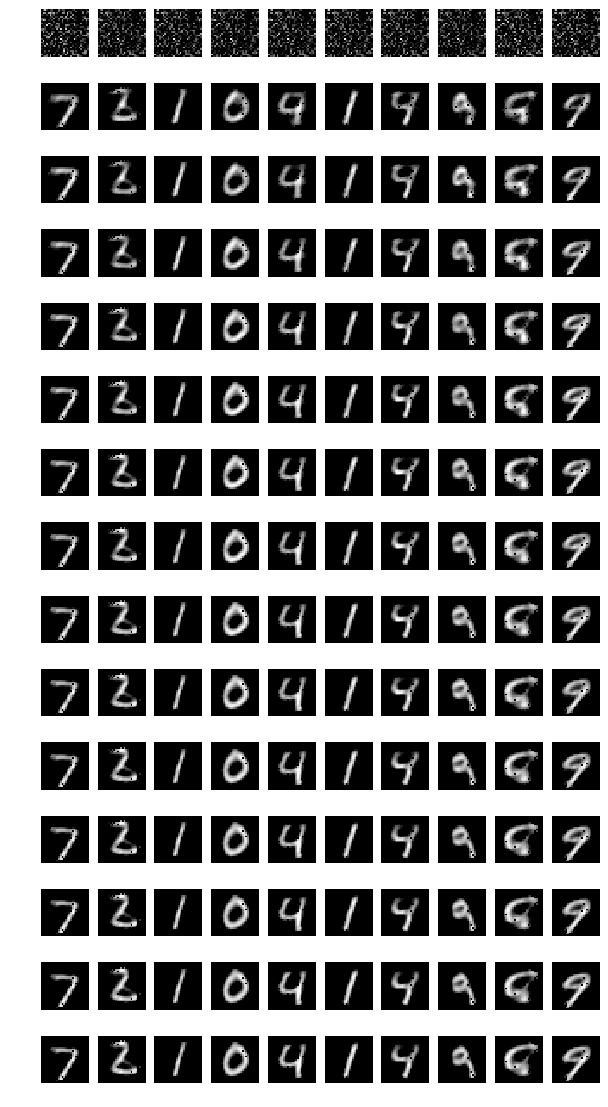

In [146]:
l = x_train.shape[0]
batch_size = 100
total_epoch = 15
losses = np.zeros(total_epoch)
fig, ax = plt.subplots(nrows=total_epoch, ncols=10, figsize=(10, 20))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

#print ("Variables before training")
#for var in tf.global_variables():
#    print (var.name, sess.run(var))

with tf.train.MonitoredSession() as sess:
    for epoch in range(total_epoch):
        #This excutes the calculation of loss, and reconstruction/decoding of test dataset
        test_loss,test_reconst = sess.run([loss, data_reconst], {data: x_test,constant_sigma_bool:True}) 
        
        print('Epoch', epoch, 'loss', test_loss)
        losses[epoch] = test_loss
        
        #prints the first 10 test images generated by autoencoders at each epoch
        ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        plot_samples(ax[epoch, 0:], test_reconst[0:10])
        
        #the model is trained on training datasets, in batch of 100
        for k in range(0, 60000, batch_size):
            batch_num = k/(batch_size)
            batch_train = x_train[k:k + batch_size]
            sess.run(optimize, {data: batch_train}) #This trains the optimizer
            

## Plotting 100 random examples

In [147]:
'''
reshape_to_3D reshapes the reconstructed images (in 2D array) into 3D for the purpose of visualisation
Input x_2D: 2D array, the flattened version of reconstruction from MNIST dataset
Output x_3D: 3D array
'''
def reshape_to_3D(x_2D):
    x_3D = x_2D.reshape(x_2D.shape[0],int(x_2D.shape[1]**(1/2)),int(x_2D.shape[1]**(1/2)))
    return x_3D

'''
Plot reconstructed images, in 10 x 10 grid
'''
def plot_100_xhat(x_hat):
    x_hat = reshape_to_3D(x_hat) * 255.0
    fig = plt.figure(figsize=(10,8))
        
    for i in range(100):
        ax = fig.add_subplot(10, 10, i+1)
        ax.imshow(x_hat[i], cmap='gray')
    
    fig.suptitle('Autoencoded Test Sample')
    plt.show()


'''
Plot original test images, in 10 x 10 grid
''' 
def plot_100_xtest(x_test):
    fig = plt.figure(figsize=(10,8))
        
    for i in range(100):
        ax = fig.add_subplot(10, 10, i+1)
        ax.imshow(x_test[i]*255.0, cmap='gray')
    
    fig.suptitle('Original Test Sample')
    plt.show()

'''
Plot test error per epoch
'''
def plot_test_losses(losses, const_sigma=True):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.show()

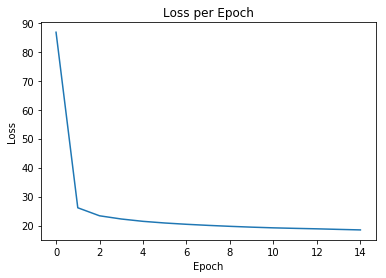

In [148]:
plot_test_losses(losses, const_sigma=True)

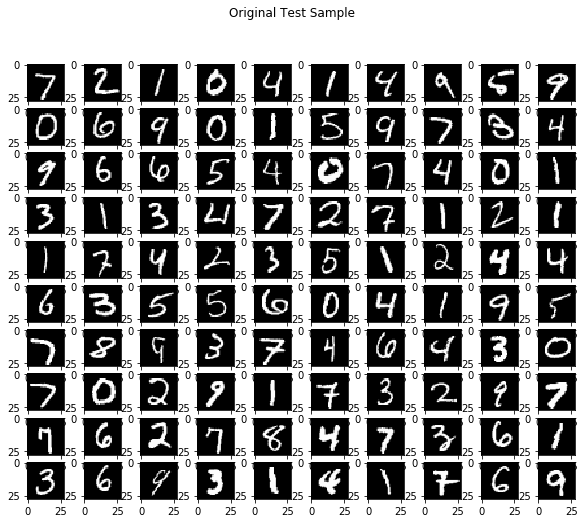

In [149]:
plot_100_xtest(x_test)

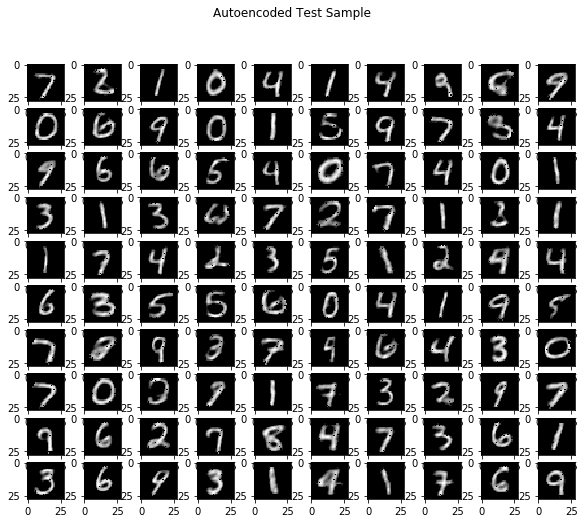

In [150]:
plot_100_xhat(test_reconst[0:100])

## Training with sigma_x as a layer in Neural Network

Set constant_sigma_bool to be False, so $\sigma_z$ is computed as a layer in the Neural Network

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 loss 86.73511
Epoch 1 loss 27.845022
Epoch 2 loss 25.259434
Epoch 3 loss 24.073187
Epoch 4 loss 22.968384
Epoch 5 loss 21.997551
Epoch 6 loss 21.4866
Epoch 7 loss 21.102875
Epoch 8 loss 20.801025
Epoch 9 loss 20.244846
Epoch 10 loss 20.058353
Epoch 11 loss 19.821646
Epoch 12 loss 19.664389
Epoch 13 loss 19.503521
Epoch 14 loss 19.329926
Epoch 15 loss 19.241327
Epoch 16 loss 19.127502
Epoch 17 loss 18.990692
Epoch 18 loss 18.892342
Epoch 19 loss 18.798605


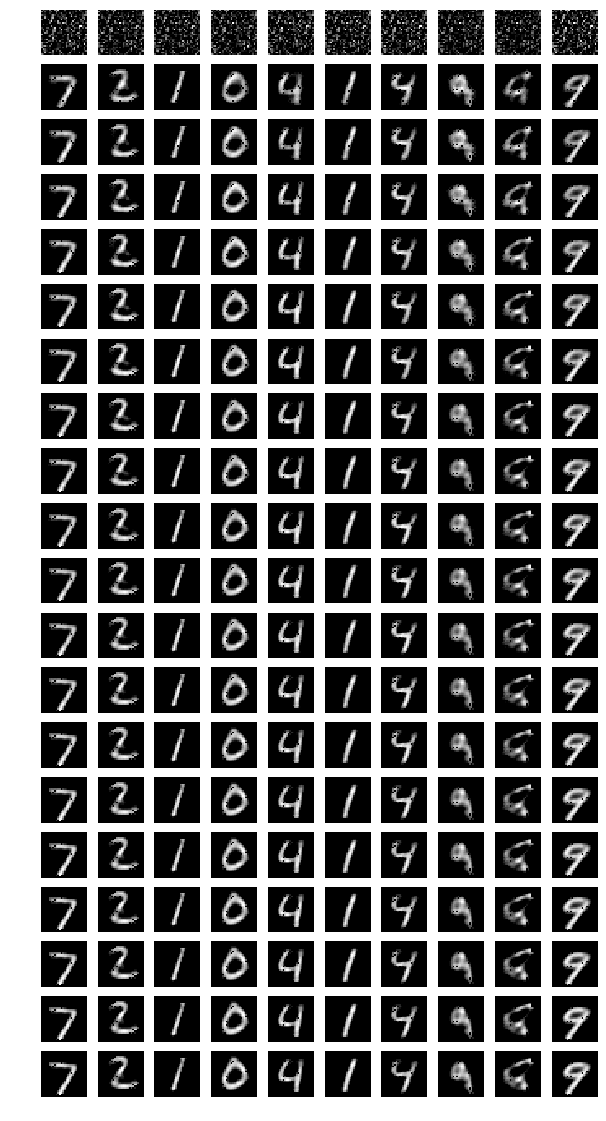

In [158]:
l = x_train.shape[0]
batch_size = 100
total_epoch = 20
losses = np.zeros(total_epoch)
fig, ax = plt.subplots(nrows=total_epoch, ncols=10, figsize=(10, 20))

sess = tf.Session()
sess.run(tf.global_variables_initializer())


with tf.train.MonitoredSession() as sess:
    for epoch in range(total_epoch):
        test_loss,test_reconst = sess.run([loss, data_reconst], {data: x_test,constant_sigma_bool:False}) 
        
        print('Epoch', epoch, 'loss', test_loss)
        losses[epoch] = test_loss
        
        ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        plot_samples(ax[epoch, 0:], test_reconst[0:10])
        
        for k in range(0, 60000, batch_size):
            batch_num = k/(batch_size)
            batch_train = x_train[k:k + batch_size]
            sess.run(optimize, {data: batch_train}) #This trains the optimizer
            

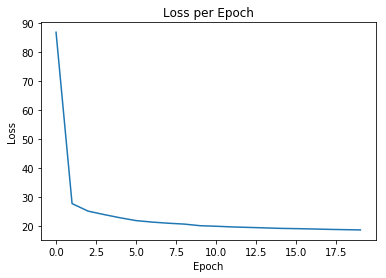

In [159]:
plot_test_losses(losses, const_sigma=False)

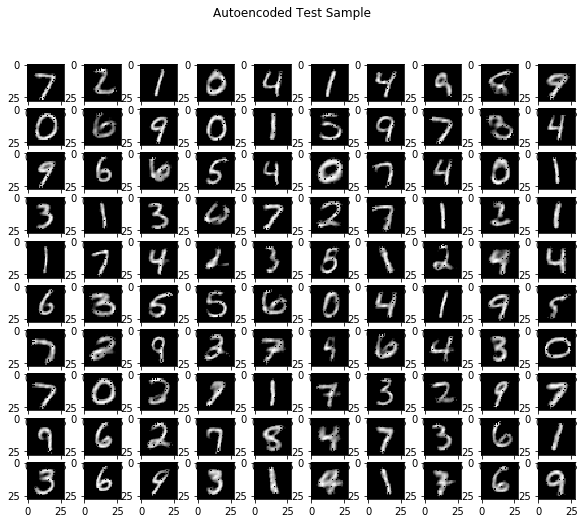

In [153]:
plot_100_xhat(test_reconst[0:100])